## Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

# Backtesting Order Flow Strategy
In the previous video, you learnt to create a trading strategy based on order flow calculated using the tick rule. In this notebook, you will learn to create python code to backtest the trading strategy based on order flow calculated using the tick rule.

The notebook is structured as follows:
1. [Read the Data](#data)
1. [Trading Signals](#tradingsignals)
1. [Backtest the Trading Strategy](#backtest)
1. [Performance Analysis](#performance)
1. [Conclusion](#conclusion)






## Import Libraries

In [1]:
# For data manipulation
import pandas as pd
import numpy as np

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# For plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

<a id='data'></a>
## Read the Data
Import the CSV file `tick_rule_es500_2013_10_02.csv` as the dataframe `tick_rule`. This CSV file has tick data in columns `bid`, `ask`, `trade_price`, `trade_size`, `tick_direction`, and `order_flow` with datetime in milliseconds as the index.

In [2]:
# Read the 'tick_rule_es500_2013_10_02.csv' csv file as 'tick_rule' dataframe
tick_rule = pd.read_csv(
    '../data_modules/tick_rule_es500_2013_10_02.csv', index_col=0)

# Convert the index of the dataframe `tick_rule` to datetime format
tick_rule.index = pd.to_datetime(tick_rule.index)

### Define the Order Flow Threshold 
Use the percentile of order flows in the last one min as the threshold for entering and exiting the trades. The 90 percentile, 75 percentile, 50 percentile, 25 percentile and 10 percentile of order flow are used in generating the trading signals. `percentile` method of `numpy` library is used to calculate the percentile of order flow in the `tick_rule` dataframe

In [3]:
# Example of calculating the 75 percentile of order flow in the 'tick_rule' dataframe
percentile_75 = np.percentile(tick_rule.order_flow, 75)
print(f'75th percentile of order flow is {percentile_75}')

75th percentile of order flow is 4.0


<a id='tradingsignals'></a>
## Trading Signals

**Long positions**

* Buy at the midpoint of the tick if the net order flow in the last one minute is greater than the 75 percentile of the order flow in the last one minute.
* If a long position is open
    * The 90 percentile of the order flow in the last one minute is considered as a threshold for take profit.
    * The 50 percentile of the order flow in the last one minute is considered as a threshold for stop loss.

**Short positions**

* Sell at the midpoint of the trade if the net order flow in the last one minute is less than the 25 percentile of the order flow in the last one minute.
* If a short position is open
    * The 10 percentile of the order flow in the last one minute is considered as a threshold for take profit.
    * The 50 percentile of the order flow in the last one minute is considered as a threshold for stop loss.

In [4]:
# Calculate the cumulative order flow and store it in the column 'cumulative_order_flow'
tick_rule['cumulative_order_flow'] = tick_rule['order_flow'].cumsum()

# Calculate the midpoint of the trade and store it in the column 'midpoint'
tick_rule['midpoint'] = (tick_rule['bid'] + tick_rule['ask']) / 2

<a id='backtest'></a>
## Backtest the Trading Strategy
Backtest the trading strategy with the trading signals defined above. Check the entry and exit conditions by looping through each trade of the `tick_rule` dataframe. If a trade is entered or exited, append the details of the trades such as `entry_time`, `exit_time`, `direction`, `entry_price`, and `exit_price` to the `trades` dataframe. <br> 

The following are the steps involved in backtesting the trading strategy. <br> <br> 

<img src="https://d2a032ejo53cab.cloudfront.net/Glossary/7WzZlDr4/tickrulebacktest-Steps.jpg"><br>

**Step-1:** Initialise the variable to keep track of the current position (pos).

**Step-2:** Next, several empty lists and DataFrames are created to store additional trading data, including a list times when trades are entered and exited (entry_time and exit_time), and dataframe with detailed information about each trade (trades).

**Step-3:** Initialise a list of all indices in the DataFrame and create a separate list of indices for the rows that fall within the previous one minute. 

**Step-4:** For each row in the `indices` list, calculate the net order flow value over the previous one minute and decide whether to enter, exit, or maintain a position based on the order flow strength. update the trading data structures as needed and print information about the trades being made. 

**Step-1:** Initialise the variable to keep track of the current position (pos).

In [5]:
# Initialise the variable pos to 0, which will be used to keep track of the current position
pos = 0

**Step-2:** Initialise empty lists and dataframe to store additional trading data.

In [6]:
# Create an empty list called entry_time that will be used to store the time at which trades are entered
entry_time = []

# Create an empty list called exit_time that will be used to store the time at which trades are exited
exit_time = []

# Initialise an empty Pandas DataFrame called 'trades' to save trade details
trades = pd.DataFrame(
    columns=['entry_time', 'exit_time', 'direction', 'entry_price', 'exit_price'])

**Step-3:** Select the Indices
In this trading strategy, we are collecting the ticks in the last one minute and calculating the net order flow. So, when we loop through the tick data, we need to make sure that the loop is starting after the first one minute. 

Create the list `indices` to save the indices of the `tick_rule` dataframe that occurred after the first one minute.

In [7]:
# Create a list of all indices in the dataframe and store it in `indices_total`
indices_total = tick_rule.index.tolist()

# Create a list of indices of ticks that happened after the first minute and store it in `indices`
indices = [x for x in indices_total if x >
           indices_total[0]+pd.Timedelta(minutes=1)]

# Create a list of indices with ticks in the previous one minute from the index of the current row
indices_in_last_one_min = []

**Step-4:** For each row in the indices list, calculate the net order flow value over the previous one minute 


<img src="https://d2a032ejo53cab.cloudfront.net/Glossary/WMgxtK8r/backtest-Horizontal.jpg" ><br>

* If there is no open position `(pos==0)`, check for long and short entry conditions
    * If the net order flow in the last one minute is greater than the threshold of the long entry and less than the long position's take-profit threshold, a long position is opened.
    * If the net order flow in the last one minute is less than the threshold of the short entry and greater than the short position's take-profit threshold, a short position is opened. <br><br>
* If there is an open long position `(pos>0)`, check for take-profit and stop-loss
    * If the net order flow in the last one minute is greater than the long position's take-profit threshold, the long position is exited.
    * If the net order flow in the last one minute is less than the long position's stop-loss threshold, the long position is exited.<br><br>
* If there is an open short position `(pos<0)`, check for take-profit and stop-loss
    * If the net order flow in the last one minute is less than the short position's take-profit threshold, the short position is exited.
    * If the net order flow in the last one minute is greater than the short position's stop-loss threshold, the short position is exited.<br><br>     

In [8]:
# Remove duplicate entries from the tick_rule dataframe, keeping only the first occurrence of each duplicated index value.
tick_rule = tick_rule[~tick_rule.index.duplicated(keep='first')]

<i> <span style="color:#FFFFFF; background:#00C001"> The following cells will not run in the browser. Download this notebook and convert the cells to "Code" type to run. </i>

<a id='performance'></a>
## Performance Analysis
The `trades` dataframe has the columns `entry_time`, `exit_time`, `direction`, `entry_price`, `exit_price`.<br>
* Calculate the profit and loss of each trade using the `direction`, `entry_price` and `exit_price`. Store the profit and loss values in the `pnl` column of the `trades` dataframe.
* Calculate the `returns` of each trade using the `pnl` and `entry_price` column. Store the returns of each trade in the `returns` column.

In [10]:
# Profit and loss of trades
trades['pnl'] = trades.direction*(trades.exit_price - trades.entry_price)

# Returns of each trade
trades['returns'] = 100 * trades['pnl']/trades['entry_price']

# Print last 5 trades
trades.tail()

,entry_time,exit_time,direction,entry_price,exit_price,pnl,returns
2013-10-02 23:50:33.129600,2013-10-02 23:50:33.129600,2013-10-02 23:50:33.648000,-1,1438.125,1438.125,-0.0,-0.0
2013-10-02 23:50:50.668800,2013-10-02 23:50:50.668800,2013-10-02 23:50:56.803200,-1,1438.125,1438.125,-0.0,-0.0
2013-10-02 23:52:19.315200,2013-10-02 23:52:19.315200,2013-10-02 23:52:23.203200,1,1438.125,1438.125,0.0,0.0
2013-10-02 23:55:13.065600,2013-10-02 23:55:13.065600,2013-10-02 23:55:14.016000,-1,1438.125,1438.125,-0.0,-0.0
2013-10-02 23:57:52.128000,2013-10-02 23:57:52.128000,2013-10-02 23:58:09.667200,-1,1437.875,1437.875,-0.0,-0.0


Calculate the cumulative return of each trade using the `cumprod()` method and `returns` column. 

In [11]:
# Calculate the cumulative return
cumulative_return = (1 + trades['returns']).cumprod() - 1

# Print cumulative returns of the strategy
print(
    f'Cumulative returns of the strategy: {np.round(cumulative_return[-1],4)} %')

Cumulative returns of the strategy: 0.127 %


## Plot the Performance
Create a line chart to visualise the cumulative returns of the trading strategy.

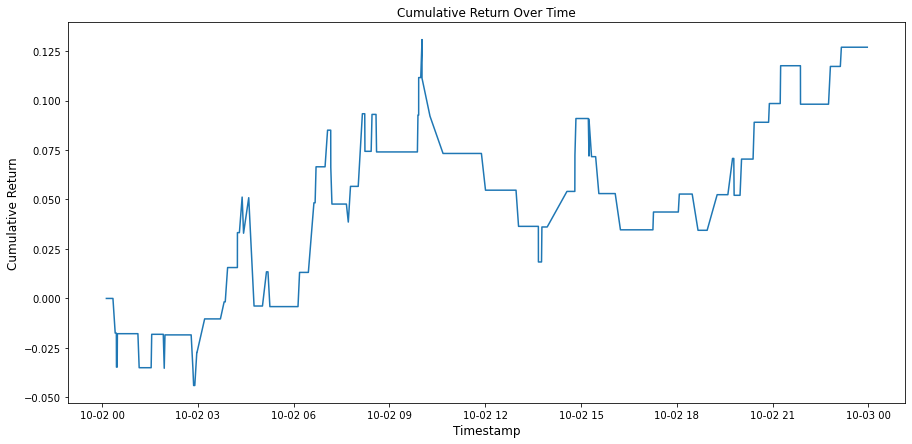

In [12]:
# Create a figure and subplot with a specific size
fig, ax = plt.subplots(figsize=(15, 7))

# Plot the cumulative return
ax.plot(cumulative_return.index, cumulative_return.values)

# Set the x-axis label and font size
ax.set_xlabel('Timestamp', fontsize=12)

# Set the y-axis label
ax.set_ylabel('Cumulative Return', fontsize=12)

# Set the title of the plot
ax.set_title('Cumulative Return Over Time')

# Display the plot
plt.show()

<a id='conclusion'></a>
## Conclusion
In this notebook, we have backtested the order flow trading strategy with a look-back period of 1 min. The performance of the strategy will be different for different look-back periods and thresholds to calculate the entry, and exit conditions of the trade. Try the same approach to backtest this trading strategy on order flow calculated by the bulk volume classification method. <br> <br>